In [4]:
import sys
import os


import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pylab as plt


In [5]:
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def load_ipython_extension(ip):
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")

In [6]:
sns.set_style('ticks')
sns.set_context('talk')

# Read Suite2p output


In [7]:
traces = np.load('/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/Planes/Plane_2/suite2p/plane0/F.npy')
neu = np.load('/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/Planes/Plane_2/suite2p/plane0/Fneu.npy')
spks = np.load('/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/Planes/Plane_2/suite2p/plane0/spks.npy')
ithisaCellBinary = np.load('/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/Planes/Plane_2/suite2p/plane0/iscell.npy') # with threshold set at 0.5, left column is a boolean indicator of whether an roi is likely to be a neuron. 
stat_dict = np.load('/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/Planes/Plane_2/suite2p/plane0/stat.npy', allow_pickle = True)[0]

In [8]:
# define some arguments for later:
numCells, numFramesTotal = traces.shape
numFramesOdorTrial = 136
numOdors = 10
numTrials = 8
numOdorTrials = 80

# Read in odor sequence information

In [9]:
import csv

odorPath = '/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/20200220_serial_mouse#164.csv'


#allocate an array to store the sequence of odors (10) for each trial (8)
trialOdorArray = np.zeros((numTrials,numOdors)).astype(int)

trialID = 0 # flag for indexing trialOdorArray
with open(odorPath) as f:
    readCSV = csv.reader(f, delimiter=",")
    for row in readCSV:
        if 'About to pick' not in row:
            continue
        else:
            thisTrialSequence = []
            for i in range(numOdors):
                thisOdor = int(next(readCSV)[0])
                trialOdorArray[trialID,i]=thisOdor
            trialID+=1 # update flag
            
#                 print(thisOdor)



In [10]:
trialOdorArray

array([[27,  2, 12, 11, 25, 10, 24,  9, 26,  1],
       [12, 26,  1,  9,  2, 10, 24, 11, 27, 25],
       [ 2, 10,  1, 27,  9, 26, 24, 12, 11, 25],
       [10, 27,  2,  9, 11, 26,  1, 12, 24, 25],
       [ 1, 27,  2, 10, 11, 26, 25,  9, 24, 12],
       [11, 27, 24, 10,  2, 26,  9,  1, 25, 12],
       [ 2, 11, 24, 10,  9, 26, 27,  1, 25, 12],
       [ 9, 11, 26, 10, 27,  2, 24,  1, 25, 12]])

 # read in Prairie output for metadata. 

In [11]:

from xml.dom import minidom
doc = minidom.parse('/Volumes/Simon_2018/DATA/2P/RAW/20200220/Mouse#164/Exp/TSeries-02202020-1127-001/TSeries-02202020-1127-001.xml')
sequence = doc.getElementsByTagName('Sequence')
numFrames_XML = len(sequence)

# is number of suite2p frames equal to the number of xml frames?
print(f'correct number of frames: {numFramesTotal==numFrames_XML}')

correct number of frames: True


In [12]:
# get xmlFrameIDS, framePeriods, relativeTimes, absoluteTimes. 
#These values are specific to each experiment. 
#We assume there is a 1 to 1 correspondence between xml frames and suite2p frames

def getMetaDataFromXML(sequence,numFrames_XML):
    """
    Returns: xml Frame ID,
    duration of each Frame in seconds,
    relative time, 
    absolute time
    """
    framePeriods = []
    relativeTimes = []
    absoluteTimes = []
    xmlFrameIDS = []
    for xmlFrame in range(numFrames_XML):
        subFrames = sequence[xmlFrame].getElementsByTagName('Frame')
        xmlFrameID = int(sequence[xmlFrame].getAttribute('cycle'))

        #for each xml sequence there are 3 subfields called Frame. Each one  has a framePeriod associated with it. Add these to get the total time for each sequence.
        framePeriod = 0
        for subframe in subFrames:
            a = subframe.getElementsByTagName('PVStateValue')[0]
            framePeriod+=float(a.attributes.items()[1][1])

            # for the last subframe, get the relative and absolute times. 
        lastFrame = subFrames[2]
        relativeTime = float(lastFrame.getAttribute('relativeTime'))
        absoluteTime = float(lastFrame.getAttribute('absoluteTime'))

        framePeriods.append(framePeriod)
        relativeTimes.append(relativeTime)
        absoluteTimes.append(absoluteTime)
        xmlFrameIDS.append(xmlFrameID)
    return xmlFrameIDS, framePeriods, relativeTimes, absoluteTimes

xmlFrameIDS, framePeriods, relativeTimes, absoluteTimes = getMetaDataFromXML(sequence,numFrames_XML)

# on a cell by cell basis, populate our master dataframe

In [13]:
dfsAllCells = []
for cell in range(numCells):
    dfOneCell = pd.DataFrame(dict(xmlFrameID = xmlFrameIDS,
                                  suite2pFrameID = None, 
                                 framePeriod = framePeriods,
                                 frameRate = 1/np.array(framePeriods),
                                 relativeTime = relativeTimes,
                                 absoluteTime = absoluteTimes,
                                 cellID = cell,
                                 F = traces[cell,:],
                                 Fneu = neu[cell,:],
                                 deconv = spks[cell,:],
                                 odorPos = None, # the position of each odor in the pseudorandomized sequence associated with each trial.
                                 odorID = None, # the actual odorID in this position.
                                 trialID = None,
                                 cellProbBinary = ithisaCellBinary[cell][0],
                                 cellProbRaw = ithisaCellBinary[cell][1],

                                 ))

    odorTrialID = 0
    for trialID in range(numTrials):
        for odorPos in range(numOdors):
            trialOdorFrameRange = np.s_[numFramesOdorTrial*odorTrialID:numFramesOdorTrial*odorTrialID +numFramesOdorTrial]
            # for column indexing below, I need to provide the index corresponding to the name of each column, hence: list(dfOnceCell.columns).index(columnName)
            dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('suite2pFrameID')] = range(numFramesOdorTrial) #assign frame id to each odor-trial
            dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('trialID')] = trialID
            dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('odorPos')] = odorPos
            dfOneCell.iloc[trialOdorFrameRange, list(dfOneCell.columns).index('odorID')] = trialOdorArray[trialID,odorPos] # index to specific trial-odor id. 
            odorTrialID+=1
    dfsAllCells.append(dfOneCell)
    
# combine all cells into one Dataframe
DF = pd.concat(dfsAllCells,axis=0)
#subtract neuropil
DF['Fadj'] = DF.F- 0.7*DF.Fneu

In [14]:
# Resort based on odor Identity from 1-10. 
DFsorted = DF.sort_values(['cellID', 'trialID', 'odorID', 'suite2pFrameID'])

# alternatively sort by acquisition order:

# DFsorted = DF.sort_values(['cellID', 'trialID', 'odorPos', 'suite2pFrameID'])

In [22]:
print ('DF fields:\n')
print (list(DF.columns))
DFsorted

DF fields:

['xmlFrameID', 'suite2pFrameID', 'framePeriod', 'frameRate', 'relativeTime', 'absoluteTime', 'cellID', 'F', 'Fneu', 'deconv', 'odorPos', 'odorID', 'trialID', 'cellProbBinary', 'cellProbRaw', 'Fadj']


xmlFrameID suite2pFrameID  framePeriod  frameRate  relativeTime  \
1224         1225              0     0.221578   4.513081      0.147719   
1225         1226              1     0.221578   4.513081      0.369297   
1226         1227              2     0.221578   4.513081      0.590875   
1227         1228              3     0.221578   4.513081      0.812453   
1228         1229              4     0.221578   4.513081      1.034031   
...           ...            ...          ...        ...           ...   
10195       10196            131     0.221578   4.513090     29.174396   
10196       10197            132     0.221578   4.513090     29.395974   
10197       10198            133     0.221578   4.513090     29.617552   
10198       10199            134     0.221578   4.513090     29.839129   
10199       10200            135     0.221578   4.513090     30.060707   

       absoluteTime  cellID           F        Fneu     deconv odorPos odorID  \
1224     553.493719       0  920.994873  814.627808   0.000000       9      1   
1225     553.715297       0  937.047363  783.284363  54.496254       9      1   
1226     553.936875       0  930.286743  770.230042  14.208029       9      1   
1227     554.158453       0  913.211975  791.067139   0.000000       9      1   
1228     554.380031       0  918.250549  799.930237   0.000000       9      1   
...             ...     ...         ...         ...        ...     ...    ...   
10195   4482.578396     316  454.953491  418.606262   0.000000       4     27   
10196   4482.799974     316  444.793793  424.941742   0.000000       4     27   
10197   4483.021552     316  438.172821  419.806244   0.000000       4     27   
10198   4483.243129     316  475.171478  421.260406   6.600417       4     27   
10199   4483.464707     316  465.702698  436.129242   0.000000       4     27   

      trialID  cellProbBinary  cellProbRaw        Fadj  
1224        0             1.0     0.452676  350.755432  
1225        0             1.0     0.452676  388.748291  
1226        0             1.0     0.452676  391.125732  
1227        0             1.0     0.452676  359.464966  
1228        0             1.0     0.452676  358.299377  
...       ...             ...          ...         ...  
10195       7             0.0     0.047028  161.929108  
10196       7             0.0     0.047028  147.334564  
10197       7             0.0     0.047028  144.308441  
10198       7             0.0     0.047028  180.289185  
10199       7             0.0     0.047028  160.412231  

[3448960 rows x 16 columns]

In [ ]:
epochID = 1
sliceID = 0
#sframe = gl.SFrame(sframePath)
good_trials = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]

#sframe['slice'] = sliceID
#df = sframe[(sframe['epoch']==epochID) &(sframe['slice']==sliceID)&(sframe['cellProbBinary']==1)]['Frame', 'RoiSignal', 'cellID','redLabel', 'trial', 'odorPos', 'odorID', 'odorOn', 'odorOff', 'normed_traces', 'normed_stds', 'baselined1_traces', 'slice'].to_dataframe()
#df = df.loc[df.trial.isin(good_trials)]
#inh neurons only
#df = df.loc[df.redLabel==1]
epoch = DF.groupby(['trialID', 'cellID']).apply(lambda x: x.reset_index(drop = True))

# get dimensions 
#frames, cells, trials = [epoch.loc[(10,1)]['RoiSignal'].size] + [epoch[_].unique().shape[0] for _ in ['cellID','trial']]
numOdors = 10

#epoch = epoch.loc[epoch.Frame<136]

trialSet = epoch.trialID.unique()
cells = epoch.index.get_level_values('cellID').unique().shape[0]
frames =  epoch.suite2pFrameID.unique().shape[0]*numOdors
trials = len(good_trials)
epoch

# explore

In [ ]:
from collections import defaultdict
workflow_dict = defaultdict(dict)
workflow_dict['odor_info']= DFodor_info

In [16]:
#Let's pull data from this DF into an array whose dimensions will be (numCells, numTrials, numOdors, numFrames)
# the signal for each cell (i.e. F, Fneu, Fadj, deconv) is a 1-d trace... a flattened version of numTrials, numOdors, numFramesOdorTrial since in the DF above, frame changes fastest, then odorPos, then trialID
# also note, that traces have been reshuffled now according to odor identity... now sequenced 1-10.
from sklearn.preprocessing import scale
DataArray_Fadj = []
DataArray_deconv = []
for cell in range(numCells):
    Fadj_trace = DFsorted.loc[DFsorted.cellID==cell,'Fadj'].values
    deconv_trace = DFsorted.loc[DFsorted.cellID==cell,'deconv'].values
    
    
    # scale each cell's signal in its entirety
    Fadj_trace=scale(Fadj_trace)
    deconv_trace=scale(deconv_trace)

    DataArray_Fadj.append(Fadj_trace.reshape(numTrials,numOdors,numFramesOdorTrial)[None])
    DataArray_deconv.append(deconv_trace.reshape(numTrials,numOdors,numFramesOdorTrial)[None])
DataArray_Fadj = np.concatenate(DataArray_Fadj,0)
DataArray_deconv = np.concatenate(DataArray_deconv, 0)
print (DataArray_deconv.shape)

/Users/sdaste/opt/anaconda3/envs/simon/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/sdaste/opt/anaconda3/envs/simon/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/Users/sdaste/opt/anaconda3/envs/simon/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/sdaste/opt/anacond

(317, 8, 10, 136)


/Users/sdaste/opt/anaconda3/envs/simon/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/sdaste/opt/anaconda3/envs/simon/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/sdaste/opt/anaconda3/envs/simon/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/sda

In [17]:
#we can filter this array for cells that are most likely cells according to suite2p. 
#your suite2p file uses 0.5 as the threshold...
#get cellIDs that satisfy this criterion

#cellsToKeep = DFsorted.loc[DFsorted.cellProbRaw>0.5].cellID.unique()
cellsToKeep = DFsorted.loc[DFsorted.cellProbBinary>0.5].cellID.unique()

In [28]:
filteredDataArray = DataArray_Fadj[cellsToKeep,:,:,:]

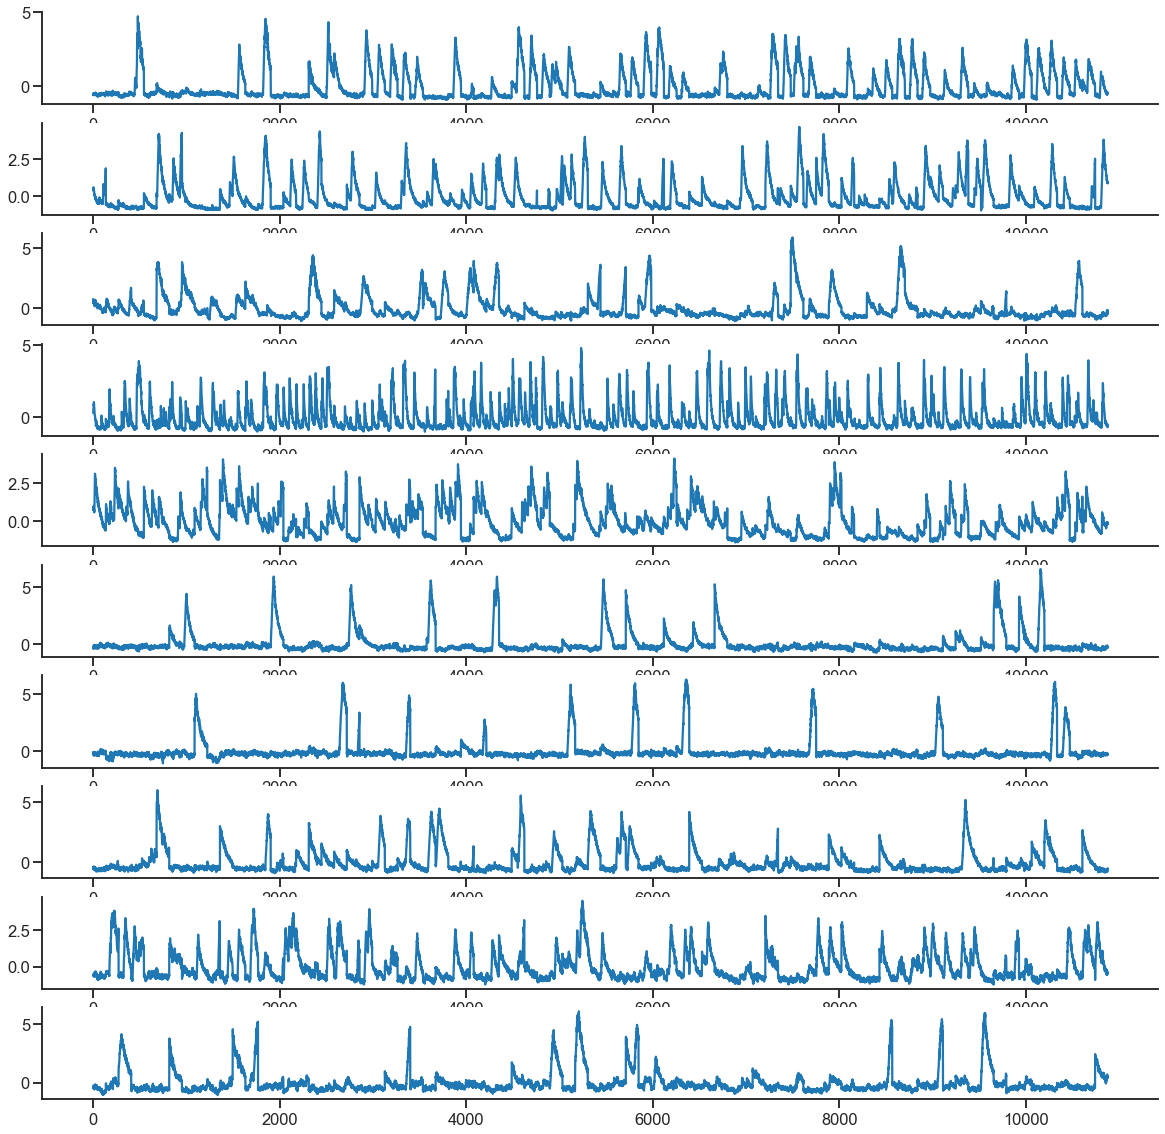

In [19]:
fig, ax = plt.subplots(10,1, figsize = (20,20)); ax = ax.ravel()
for cell in range(10):
    ax[cell].plot(filteredDataArray[cell].flatten())
sns.despine()

In [20]:
stack = filteredDataArray.transpose(0,2,1,3)

In [21]:
stack.shape

(144, 10, 8, 136)

In [24]:
def getcellsBasic(traceDict,traces, odor, cell, numTrials, window):
        import numpy as np
        "this is the basic sig_test"
        high_thresh = 1.5
        low_thresh = 1.5
        
        odor_info = gen_dict_extract('odor_info', traceDict).next()
        
        for trial in range(numTrials):
            
            on = odor_info[trial]['on'][odor+1]
            
            
            baseline_period = slice(on-window, on,1)
            odor_period = slice(on,on+window, 1)


            pre = traces[baseline_period, cell, trial]
            post = traces[odor_period, cell, trial]



            #compare mean of pre to mean of post
            
            high = pre.mean() + high_thresh*np.std(pre)
            low = pre.mean() - low_thresh*np.std(pre)

            #condition
           
            if post.mean()>high:
                yield post.mean()-pre.mean(),trial
            elif post.mean()<low:
                yield post.mean()-pre.mean(),trial

In [29]:
from collections import defaultdict

In [30]:
#from spUtils.FindSigResponses.sigTesting import getcellsBasic
numOdors = 10
numCells = 144
numTrials = 80
normed_traces=DFsorted['Fadj']
window = 10 #frames... 2 seconds. 
responseDict = defaultdict(dict)

for cell in range(numCells):
    for odor in range(numOdors):
        
       
        responseDict[odor][cell] =  [trial for trial in getcellsBasic(DFsorted, normed_traces, odor, cell, numTrials, window)]
   

NameError: name 'gen_dict_extract' is not defined

In [ ]:
import random
odor_ = random.sample(list(range(stack.shape[1])),1)[0]
cell_ = random.sample(list(range(stack.shape[0])),1)[0]
print(cell_, odor_)

cellOdor = stack[cell_][odor_]
sns.heatmap(cellOdor,  vmax = 4, vmin = -1)
plt.axvline(45, color = 'w')
plt.title(f'cell:{cell_}, odor:{odor_}')
plt.ylabel('trial')


In [ ]:
odor = filteredDataArray[...,45:60].mean(-1)
bline = filteredDataArray[...,25:40].mean(-1)
resps= odor-bline

In [ ]:
from collections import defaultdict
workflow_dict = defaultdict(dict)
workflow_dict['odor_info']= odor_
workflow_dict

In [ ]:
filteredDataArray.shape

In [ ]:
stack.shape

In [ ]:
### What is the pairwise similarity (correlation) between each trial-odor population response. 
# Rows and columns are sorted... all trials odor 1, then all trials odor 2, etc.  

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(np.corrcoef(resps.transpose(0,2,1).reshape(resps.shape[0],-1).T[:]), square = True, xticklabels=[], yticklabels=[])
for i in range(10):
    plt.axvline(8*i+8, color = 'w', linewidth = 1)
    plt.axhline(8*i+8, color = 'w', linewidth = 1)


In [ ]:
# Splitting Data for Classifier

# neural data:
X = stack()


# odors:
y = np.sample(list(range(stack.shape[1])),1)[0]

In [ ]:
# SVM classifier
# Will split up your data into "n_splits" number of groups, so n_splits should be the number of presentations of each odor.
# It is "stratified" because each group contains the same number of odors. It trains and tests n_repeats times
yy_pred = np.array([])
yy_test = np.array([])

scores = []
svm_class = SVC(kernel="linear")
rskf = RepeatedStratifiedKFold(n_splits=8, n_repeats=10)
for train_index, test_index in rskf.split(X, y):
    #     print("TRAIN:", train_index, "TEST:", test_index)
    #     print(y_test)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)
    svm_class.fit(X_train, y_train)
    y_pred = svm_class.predict(X_test)
    yy_pred = np.append(yy_pred, y_pred)
    yy_test = np.append(yy_test, y_test)
    scores.append(accuracy_score(y_test, y_pred))
    #print("correct odors:", y_test)
#     print("predicted odors:", y_pred)

In [ ]:
# Can check, eg avergage accuracy with:
np.mean(scores)

In [ ]:
# Confusion Matrix for SVM
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#print(confusion_matrix, y_test, y_pred)
#confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)    

%matplotlib widget


fig = plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    confusion_matrix(yy_pred, yy_test, labels=None, sample_weight=None, normalize="true"),
    cmap="inferno",
    xticklabels=False,
    yticklabels=False,
    annot = True
)

In [ ]:
def getcellsBasic(traceDict,traces, odor, cell, numTrials, window):
        import numpy as np
        "this is the basic sig_test"
        high_thresh = 1.5
        low_thresh = 1.5
        
        odor_info = gen_dict_extract('odor_info', traceDict).next()
        
        for trial in range(numTrials):
            
            on = odor_info[trial]['on'][odor+1]
            
            
            baseline_period = slice(on-window, on,1)
            odor_period = slice(on,on+window, 1)


            pre = traces[baseline_period, cell, trial]
            post = traces[odor_period, cell, trial]



            #compare mean of pre to mean of post
            
            high = pre.mean() + high_thresh*np.std(pre)
            low = pre.mean() - low_thresh*np.std(pre)

            #condition
           
            if post.mean()>high:
                yield post.mean()-pre.mean(),trial
            elif post.mean()<low:
                yield post.mean()-pre.mean(),trial

In [ ]:
#numOdors = workflow_dict['numOdors']
#numCells = workflow_dict['numCells']
#numTrials = workflow_dict['numTrials']
normed_traces=workflow_dict['normed_traces']['corrected_rois']
window = 16 #frames... 2 seconds. 
responseDict = defaultdict(dict)

for cell in range(numCells):
    for odor in range(numOdors):
        
       
        responseDict[odor][cell] =  [trial for trial in getcellsBasic(workflow_dict, normed_traces, odor, cell, numTrials, window)]
        